In [85]:
import pandas as pd

df = pd.read_csv('AverageHousePrice.csv')
df.head()

,Unnamed: 0,Average house price,GDP,CPI,Personal savings rate,Effective rate
0,1963-01-01,19300.0,621.672,30.44,10.9,3.00
1,1963-04-01,19400.0,629.752,30.48,10.7,3.00
2,1963-07-01,19200.0,644.444,30.69,10.1,3.00
3,1963-10-01,19600.0,653.938,30.75,11.5,3.50
4,1964-01-01,19600.0,669.822,30.94,10.7,3.25


SVR on Housing Data:

In [86]:
x = df.iloc[:, 2:].values   #
y = df.iloc[:, 1].values     #


y = y.reshape(len(y),1)# reshape y into a 2D array (len(y) rows and 1 column)


In [87]:
## Test-Train Split:

X_train = x[:-20]
y_train = y[:-20]
X_test = x[-20:]
y_test = y[-20:]

In [88]:
#Feature sacling

from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler() #create scaler object for x and y(different means and sd)
sc_y = StandardScaler()
X1 = sc_x.fit_transform(X_train)#fit x using x values, can also scale test data using original(same(dont include test values)) x fit to make predictions.
y1 = sc_y.fit_transform(y_train)# scale salary using original salary data( we can inverse at end to see predictions using sc_y object)


C:\Users\joshe\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


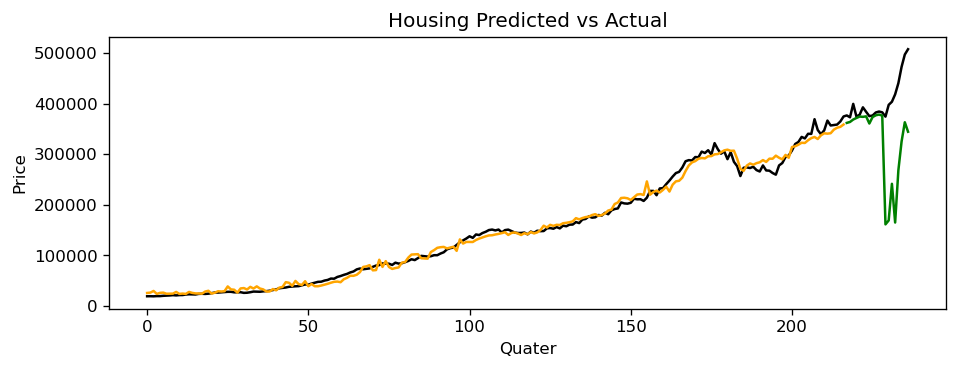

-2.034023858555451

In [95]:
#Run model

from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf', gamma='auto', epsilon=0.1)#create model  # depends on data, Gaussian Radial Basis Function.(Most common)
regressor.fit(X1, y1) #train model




import matplotlib.pyplot as plt

plt.plot(range(len(y)), y, color = 'black')
plt.plot(range(len(y1)), sc_y.inverse_transform(regressor.predict(X1)), color = 'orange')
plt.plot(range(len(y1),(len(y1)+len(y_test))), sc_y.inverse_transform(regressor.predict(sc_x.transform(X_test))), color = 'green')
plt.title('Housing Predicted vs Actual')
plt.xlabel('Quater')
plt.ylabel('Price')
plt.show()


regressor.score(X_train,y_train)

ARIMA Model on y values:

In [26]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from fmp_python.fmp import FMP
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':120})

In [24]:

#ARIMA(p,d,q)

# ADF test for stationarity(d)  H0: the time series is non-stationary

from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

#p>0.5 so we difference

ADF Statistic: 1.048176273285259
p-value: 0.9947491306482393


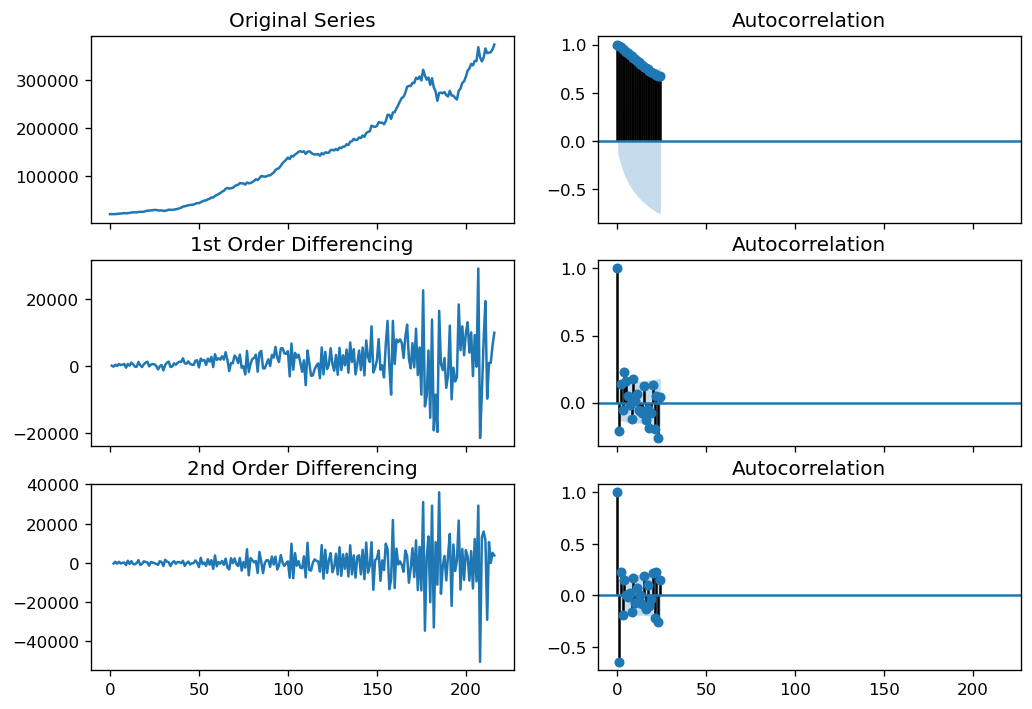

In [25]:
# Plot differenced series 


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
plot_acf(y_train, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(y_train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y_train.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

#Use d=1 as acf quick drop to 1 indicates overdifferenced


In [28]:
#Find d

from pmdarima.arima.utils import ndiffs


## Adf Test
print(ndiffs(y_test, test='adf'))  # 2

# KPSS test
print(ndiffs(y_test, test='kpss'))  # 1

# PP test:
print(ndiffs(y_test, test='pp'))  # 1


2
1
1


<Figure size 1080x360 with 0 Axes>

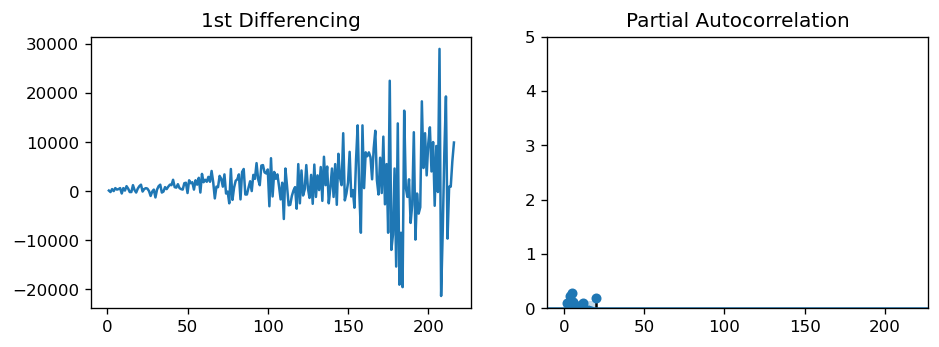

In [29]:

##Find p through the Partial Autocorrelation (PACF) plot

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
plt.figure(figsize=(9,3), dpi=120)
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y_train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y_train.diff().dropna(), ax=axes[1], lags=20, zero=False)


plt.show()

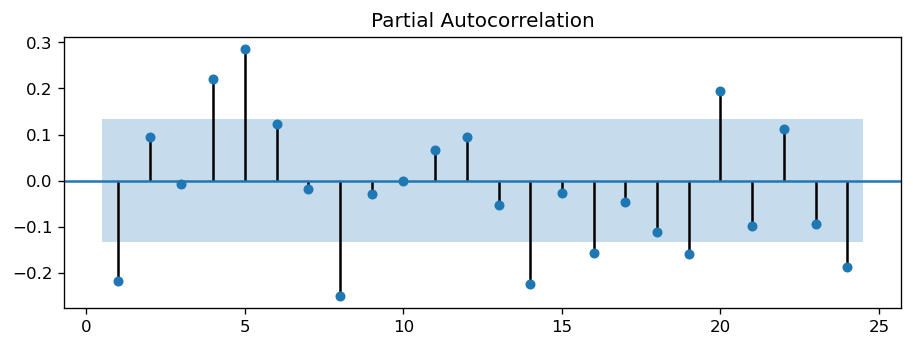

In [35]:
#Better view
plot_pacf(y_train.diff().dropna(), zero=False)
plt.show()

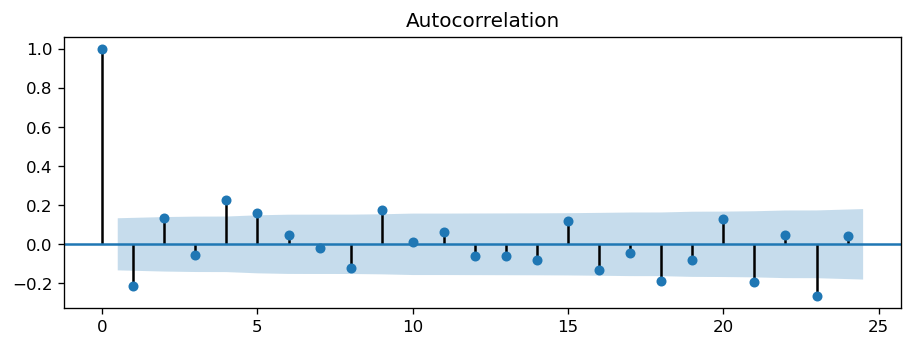

In [36]:
#Find q from ACF
plot_acf(y_train.diff().dropna())
plt.show()
#1 or 4 

In [66]:


#Fit ARIMA Model
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

# 4,1,1 ARIMA Model summary(mles dont converge)
model = ARIMA(df[:-20]['Average house price'], order=(4,1,1))    #seasonal_order=(7,1,7,40)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                               ARIMA Model Results                               
Dep. Variable:     D.Average house price   No. Observations:                  216
Model:                    ARIMA(4, 1, 1)   Log Likelihood               -2163.301
Method:                          css-mle   S.D. of innovations           5405.394
Date:                   Tue, 02 Aug 2022   AIC                           4340.603
Time:                           15:15:20   BIC                           4364.230
Sample:                                1   HQIC                          4350.148
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1651.2000    600.255      2.751      0.006     474.722    2827.678
ar.L1.D.Average house price     0.2744      0.113      2

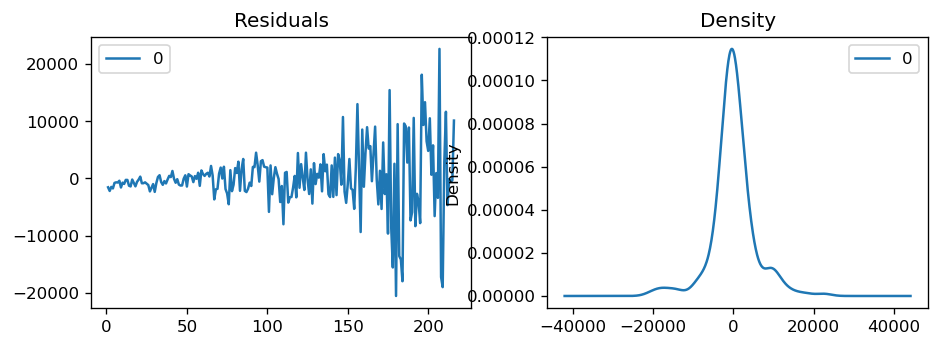

In [54]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


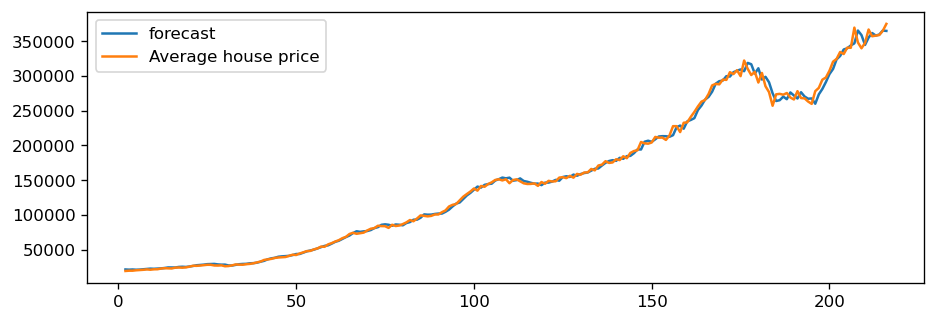

In [55]:
#real vs predicted
model_fit.plot_predict(dynamic=False)
plt.show()


                               ARIMA Model Results                               
Dep. Variable:     D.Average house price   No. Observations:                  216
Model:                    ARIMA(4, 1, 4)   Log Likelihood               -2147.009
Method:                          css-mle   S.D. of innovations           4971.126
Date:                   Tue, 02 Aug 2022   AIC                           4314.018
Time:                           15:16:17   BIC                           4347.771
Sample:                                1   HQIC                          4327.654
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1645.8330    550.159      2.992      0.003     567.541    2724.124
ar.L1.D.Average house price     1.2123      0.202      5

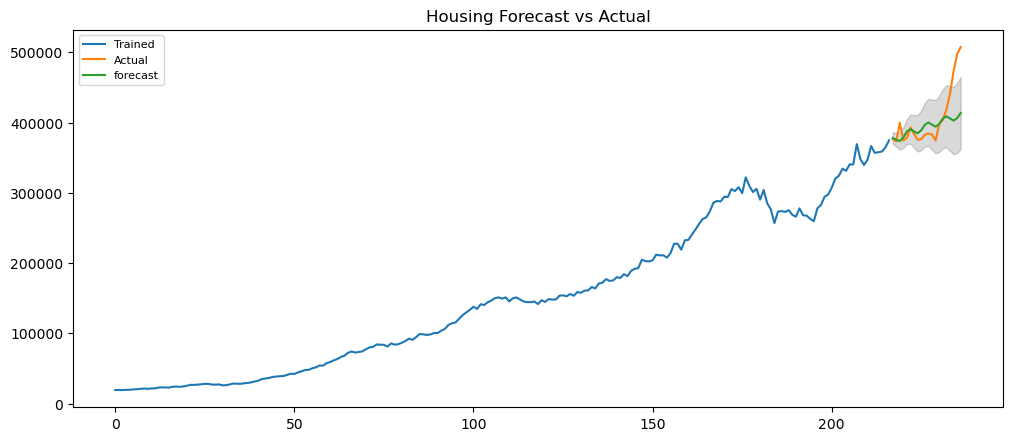

In [68]:
# Build Model
  ###8 datapoints = 1 trading day
model = ARIMA(df[:-20]['Average house price'], order=(4, 1, 4))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(df[-20:]['Average house price']), alpha=0.1)  # 90% conf

# Make as pandas series
fc_series = pd.Series(fc, index=(df[-20:]['Average house price']).index)
lower_series = pd.Series(conf[:, 0], index=(df[-20:]['Average house price']).index)
upper_series = pd.Series(conf[:, 1], index=(df[-20:]['Average house price']).index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df[:-20]['Average house price'], label='Trained')
plt.plot(df[-20:]['Average house price'], label='Actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Housing Forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [69]:
#All Accuracy tests

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
  #  acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, (df[-20:]['Average house price']).values)


{'mape': 0.04866487508667087,
 'me': -10941.01474676262,
 'mae': 21779.832994387427,
 'mpe': -0.020110582723553563,
 'rmse': 35625.36605555607,
 'corr': 0.6895965864162358,
 'minmax': 0.0481931630864304}

                               ARIMA Model Results                               
Dep. Variable:     D.Average house price   No. Observations:                  236
Model:                    ARIMA(8, 1, 1)   Log Likelihood               -2403.684
Method:                          css-mle   S.D. of innovations           6395.558
Date:                   Tue, 02 Aug 2022   AIC                           4829.368
Time:                           15:52:34   BIC                           4867.470
Sample:                                1   HQIC                          4844.727
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        2195.5055    689.151      3.186      0.001     844.794    3546.217
ar.L1.D.Average house price     0.1235      0.308      0

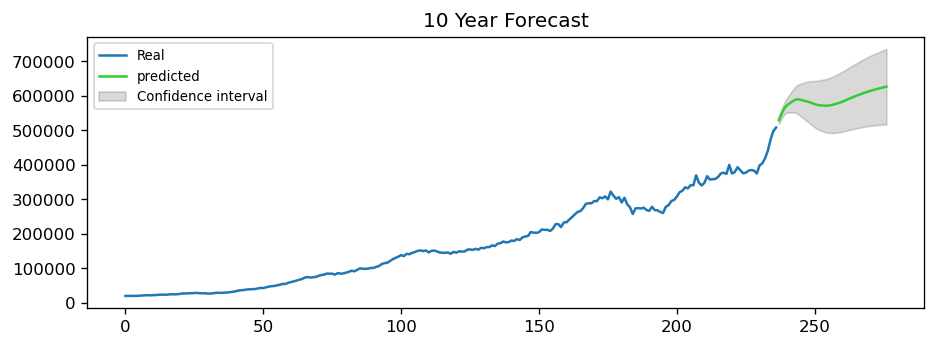

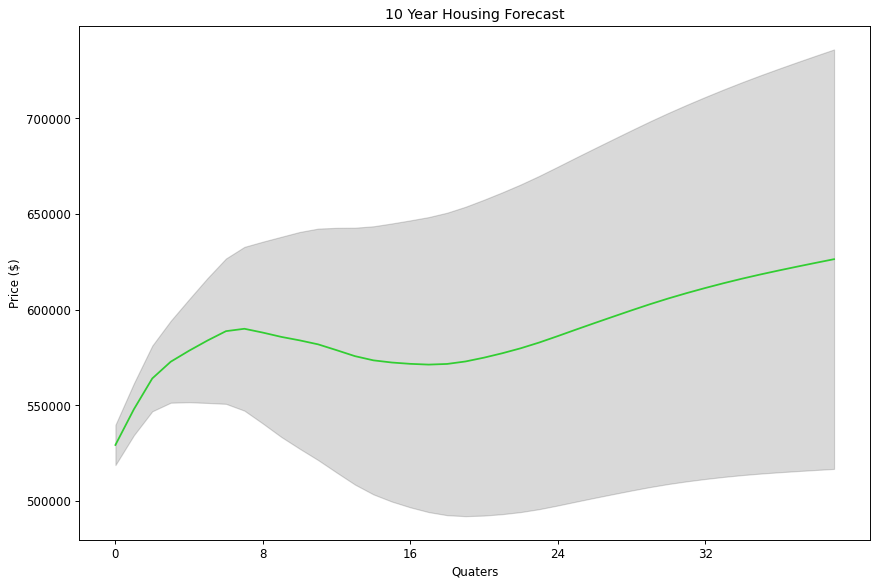

In [84]:
# 10 Year Forecast



model = ARIMA(df['Average house price'], order=(8, 1, 1))
fitted = model.fit(disp=-1) 
print(fitted.summary())

#fc, confint = model.predict(fitted, start=len(stockdata.close), end=len(stockdata.close)+40) #n_periods = 24
fc, se, confint = fitted.forecast(40, alpha=0.1)  # 90% conf



index_of_fc = np.arange(len(df['Average house price']), len(df['Average house price'])+40)



# make series for plotting confidence intervals
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
#print(fc_series)
#print(lower_series)
# Plot


plt.plot((df['Average house price']), label = "Real")
plt.plot(fc_series, color='limegreen', label = "predicted")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label="Confidence interval")

plt.title("10 Year Forecast")
plt.legend(loc='upper left', fontsize=8)
plt.show()

#Plot forcast


predictions = fc_series.reset_index(drop=True)

plt.figure(figsize=(12,8), dpi=85)
x_ticks = np.arange(0, 40, 8)
plt.xticks(x_ticks)
plt.plot(predictions, color="limegreen")
plt.fill_between((lower_series.reset_index(drop=True)).index, 
                 lower_series.reset_index(drop=True), 
                 upper_series.reset_index(drop=True), 
                 color='k', alpha=.15)
plt.title("10 Year Housing Forecast")
plt.xlabel("Quaters")
plt.ylabel("Price ($)")
plt.show()